# Preprocessing: 
- Upsampling data by time-stretch and pitch shift
- Stratified train test split for balanced classes

In [1]:
import librosa # Audio processing library
import numpy as np
import IPython.display # For playing the audio in jupyter notebook 
import librosa.display # For displaying spectrograms
import os
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf # to write the files 

In [2]:
path = "../../Downloads/IEMOCAP_full_release/Sorted/"
emotions = os.listdir(path)

# Check the class distribution:
distribution = dict()
for emotion in emotions:
    count = len([item for item in os.listdir(f"{path}/{emotion}")])
    distribution[emotion] = count

distribution

{'Excited': 2501,
 'Frustration': 3712,
 'Happiness': 495,
 'Sadness': 1181,
 'Neutral': 527,
 'Disgust': 4,
 'Surprise': 24,
 'Other': 59,
 'Fear': 133,
 'Anger': 1165}

Text(0.5, 1.0, 'Class Distribution of Emotions')

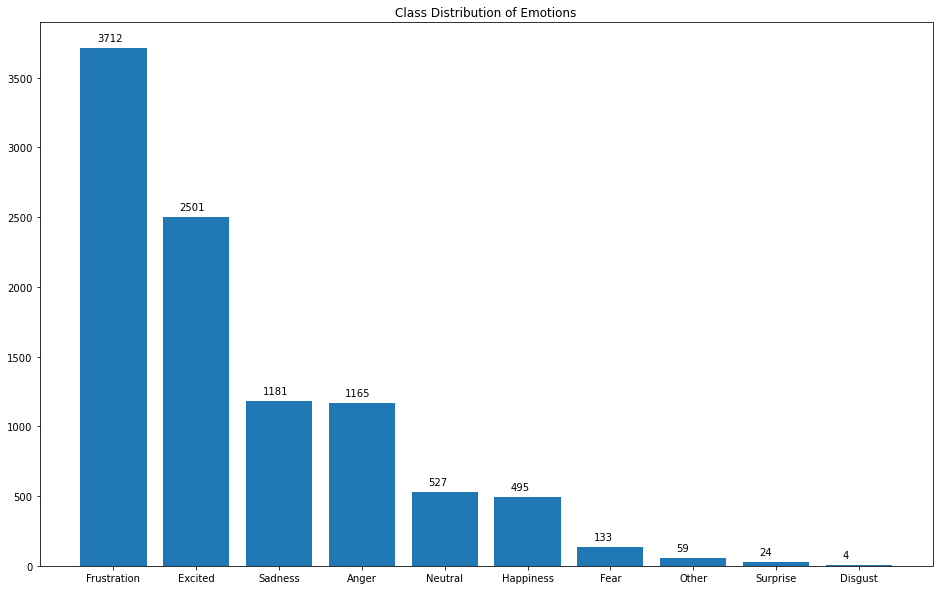

In [3]:
df = pd.DataFrame.from_dict(distribution, orient="index", columns=["count"])
x = list(df.sort_values(by="count", ascending=False).index)
y = [value[0] for i, value in enumerate(df.sort_values(by="count", ascending=False).values)]

plt.figure(figsize=(16,10))
# Making text labels:

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i-0.2,y[i]+50,y[i])
addlabels(x, y)
plt.bar(x, y)
plt.title("Class Distribution of Emotions")

# How to Upsample Data:

In [6]:
testing, sr = librosa.load("../../Downloads/IEMOCAP_full_release/Sorted/Anger/Ses01F_impro01_F012.wav", sr = 44100)

In [7]:
IPython.display.Audio(data=testing, rate=sr)

In [8]:
def data_twister(y, rate=0.9, n_steps=-1, sr = 44100): # stretches the audio and shifts the pitch. Slows it by a factor of 0.9 and shifts it down by 1
    time_stretched_y = librosa.effects.time_stretch(y, rate=rate)
    pitch_shift_time_stretched = librosa.effects.pitch_shift(time_stretched_y, n_steps=n_steps, sr = sr)
    return pitch_shift_time_stretched

In [9]:
new_y = data_twister(testing, n_steps = -1)
new_y_2 = data_twister(testing, n_steps = -2)

In [10]:
IPython.display.Audio(data=new_y_2, rate=sr)

In [11]:
# Spectrogram: Discrete Fourier Transform where each data point (cut by sampling rate)  frequency is binned.
S = np.abs(librosa.stft(testing))
S1 = np.abs(librosa.stft(new_y))

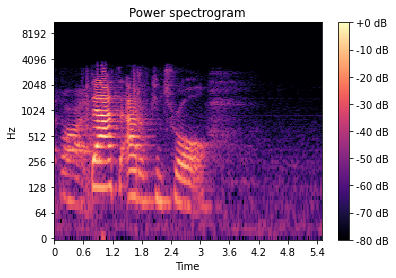

In [12]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

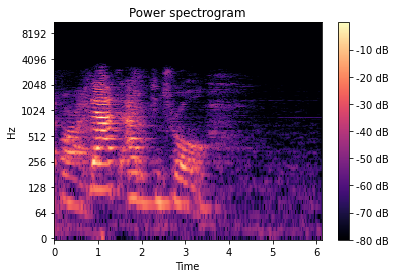

In [13]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S1,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## There is a difference between the two spectrograms

### Data Preprocessing:
- We will combine `Fear`, `Other`, `Surprise`, `Disgust` and `Neutral` into `Other`
- We will try to upsample the classes with less than 2000 data by performing time-stretch and pitch-shift
- We will first apply the transformation per each class, so that the items in the class is doubled. Then if data is still less than 2000, we will perform the transformation with different parameters

In [15]:
# New folder: Other
path = "../../Downloads/IEMOCAP_full_release/DATA/"
emotions = os.listdir(path)

# Check the class distribution:
distribution = dict()
for emotion in emotions:
    count = len([item for item in os.listdir(f"{path}/{emotion}")])
    distribution[emotion] = count

distribution

{'Excited': 2501,
 'Frustration': 3712,
 'Happiness': 495,
 'Sadness': 1181,
 'Other': 747,
 'Anger': 1165}

In [16]:
# Loop to create file with the function twisted:
for emotion in distribution.keys():
    emotionCount = len(os.listdir(f"{path}{emotion}"))
    if emotionCount < 1000:
        print(f"Working on {emotion}...")
        for file in os.listdir(f"{path}{emotion}"):
            data, sr = librosa.load(f"{path}{emotion}/{file}", sr = 44100)
            new_data = data_twister(data, rate = 0.9, n_steps = -1, sr = 44100)
            sf.write(f"{path}{emotion}/{file[:-4]}_new.wav", new_data, samplerate=44100)

Working on Happiness...
Working on Other...


In [17]:
path = "../../Downloads/IEMOCAP_full_release/DATA/"
emotions = os.listdir(path)

# Check the class distribution:
distribution = dict()
for emotion in emotions:
    count = len([item for item in os.listdir(f"{path}/{emotion}")])
    distribution[emotion] = count

distribution

{'Excited': 2501,
 'Frustration': 3712,
 'Happiness': 990,
 'Sadness': 1181,
 'Other': 1494,
 'Anger': 1165}

## To fulfill Happiness data to be 1000, we will randomly select and upsample 10 data

In [18]:
path = "../../Downloads/IEMOCAP_full_release/DATA/"
emotions = os.listdir(path)

# Check the class distribution:
distribution = dict()
for emotion in emotions:
    count = len([item for item in os.listdir(f"{path}/{emotion}")])
    distribution[emotion] = count

distribution

{'Excited': 2501,
 'Frustration': 3712,
 'Happiness': 1000,
 'Sadness': 1181,
 'Other': 1494,
 'Anger': 1165}

# Splitting data

In [7]:
import multiprocessing as mp

In [8]:
def get_list(emotion):
    path = "../../Downloads/IEMOCAP_full_release/DATA/"
    # A list to contain all the files and another list to contain all the labels
    fileNames = []
    labelNames = []
    count = 0
    for file in os.listdir(f"{path}{emotion}"):
        data, sr = librosa.load(f"{path}{emotion}/{file}", sr = 44100)
        S = np.abs(librosa.stft(data))
        if count < 1000 and S.shape[1] < 1500:
            fileNames.append(f"{path}{emotion}/{file}")
            labelNames.append(emotion)
            count += 1
        elif count == 1000:
            break
    return fileNames, labelNames

In [10]:
path = "../../Downloads/IEMOCAP_full_release/DATA/"
emotions = os.listdir(path)

with mp.Pool() as p:
    results = p.map(get_list, emotions)

In [13]:
names = [item[0] for item in results]

In [14]:
names

[['../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses03M_script01_3_M018.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses02F_script01_3_F027.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses04M_impro08_F024.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses01M_script03_1_F018.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses05M_script03_2_F001.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses05F_script03_1_M007.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses02F_script03_1_F005.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses01M_impro07_F005.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses01F_impro07_M002.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses02M_script03_1_F026.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses01M_impro07_F014.wav',
  '../../Downloads/IEMOCAP_full_release/DATA/Excited/Ses05F_impro07_M000.wav',
  '../../Downloads/IEMOCAP_full

In [15]:
labels = [item[1] for item in results]

In [16]:
labels

[['Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',
  'Excited',

In [5]:
len(fileNames) == len(labelNames)

True

In [6]:
for item in fileNames:
    print(len(item))

1000
1000
999
1000
1000
1000


In [7]:
# Happiness has 1 data missing, its not a problem, we can manually append one data to it
for item in fileNames:
    if len(item) < 1000:
        item.append(item[5]) # Randomly index to append
for item in labelNames:
    if len(item) < 1000:
        item.append(item[0])

In [8]:
for item in fileNames:
    print(len(item))

1000
1000
1000
1000
1000
1000


In [9]:
for item in labelNames:
    print(len(item))

1000
1000
1000
1000
1000
1000


In [10]:
# We need to flatten the list
fileNames = [item for sublist in fileNames for item in sublist]
labelNames = [item for sublist in labelNames for item in sublist]

In [11]:
len(fileNames) == len(labelNames)

True

In [12]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(fileNames, labelNames, test_size = 0.2, random_state=442, stratify = labelNames)

In [14]:
# We can see that the classes are equally distributed
Counter(y_train).values()

dict_values([800, 800, 800, 800, 800, 800])

In [16]:
import pickle
with open('train_pathList.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('test_pathList.pkl', 'wb') as f:
    pickle.dump(X_valid, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_valid, f)

In [23]:
# What is the file with maximum length in our data?
maximum = 0
maximum_filename = ''
train_input = []

for file in fileNames:
    data, sr = librosa.load(file, sr=44100)
    S = np.abs(librosa.stft(data))
    if S.shape[1] > maximum:
        maximum = S.shape[1]
        maximum_filename = file
print(maximum_filename, maximum)

../../Downloads/IEMOCAP_full_release/DATA/Other/Ses01F_script02_2_M016_new.wav 1497


In [24]:
# In Training data there are files with shape of 2749, its length is 31 seconds
data, sr = librosa.load("../../Downloads/IEMOCAP_full_release/DATA/Other/Ses01F_script02_2_M016_new.wav", sr = 44100)

In [25]:
IPython.display.Audio(data=data, rate=sr)